In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Define column headers
headers = ['unit_number','time_in_cycles','setting_1','setting_2','setting_3','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

In [ ]:
#Swap out the files for whichever ones you'd like to review.  I.e. FD001, FD002, but make sure to follow the naming
#convention
# Read the training data
train_file_path = 'train_FD001.txt'
train_data = pd.read_csv(train_file_path, delim_whitespace=True, header=None, names=headers)

# Read the test data
test_file_path = 'test_FD001.txt'
test_data = pd.read_csv(test_file_path, delim_whitespace=True, header=None, names=headers)

# Read the RUL data
rul_file_path = 'RUL_FD001.txt'
rul_data = pd.read_csv(rul_file_path, header=None, names=['RUL'])

In [86]:
# Calculate RUL for the training data
max_cycle = train_data.groupby('unit_number')['time_in_cycles'].max().reset_index()
max_cycle.columns = ['unit_number', 'max_cycle']
train_data = train_data.merge(max_cycle, on='unit_number')
train_data['RUL'] = train_data['max_cycle'] - train_data['time_in_cycles']
train_data = train_data.drop(columns=['max_cycle'])

In [87]:
train_data[:195]

,unit_number,time_in_cycles,setting_1,setting_2,setting_3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,...,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295,1
191,1,192,0.0009,-0.0000,100.0,518.67,643.54,1601.41,1427.20,14.62,...,2388.32,8110.93,8.5113,0.03,396,2388,100.0,38.48,22.9649,0
192,2,1,-0.0018,0.0006,100.0,518.67,641.89,1583.84,1391.28,14.62,...,2388.06,8137.72,8.3905,0.03,391,2388,100.0,38.94,23.4585,286
193,2,2,0.0043,-0.0003,100.0,518.67,641.82,1587.05,1393.13,14.62,...,2387.98,8131.09,8.4167,0.03,392,2388,100.0,39.06,23.4085,285


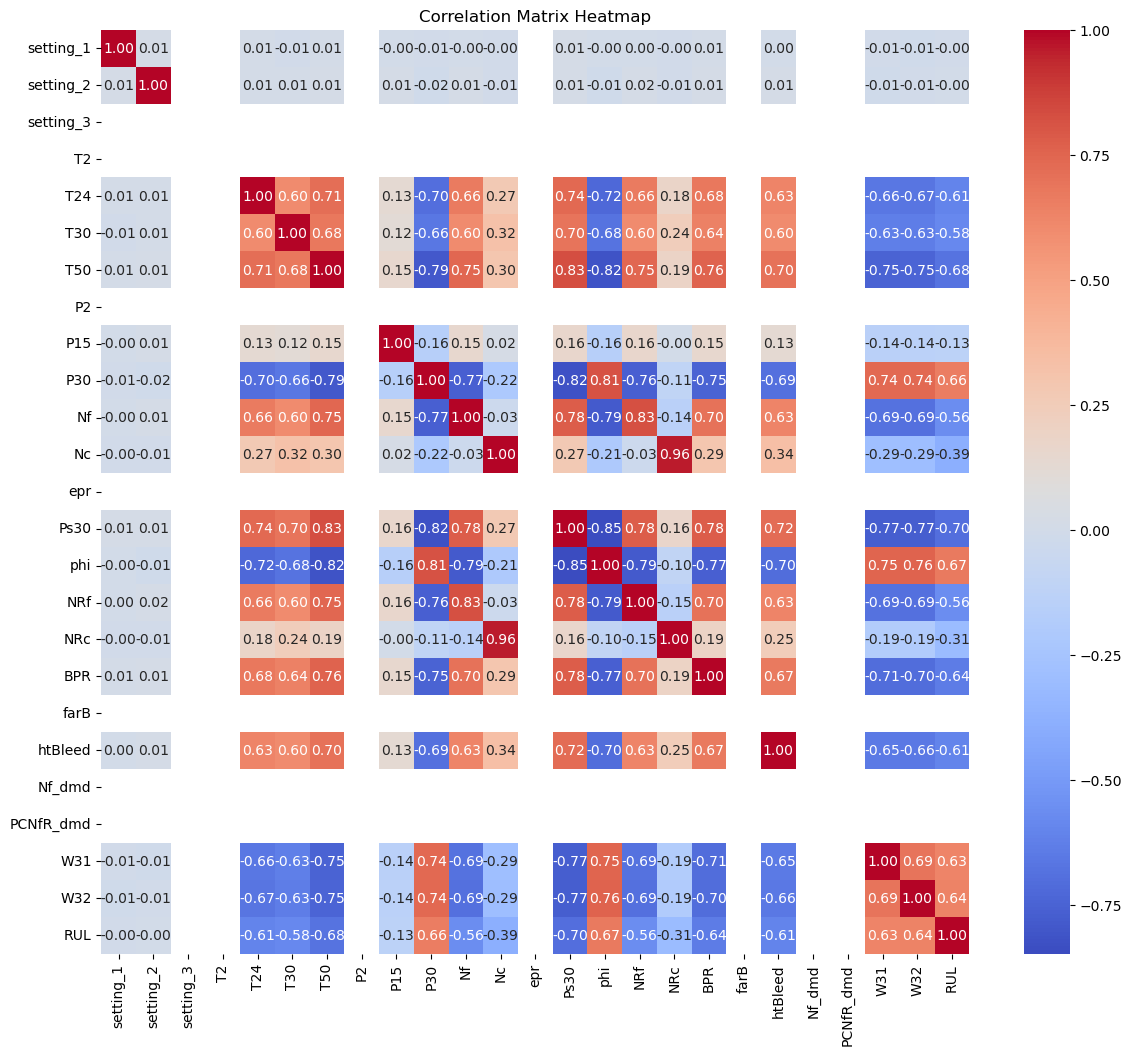

In [88]:
# Drop unnecessary columns
correlation_data = train_data.drop(columns=['unit_number', 'time_in_cycles'])

# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

      Feature  Correlation
0   setting_1    -0.003198
1   setting_2    -0.001948
2   setting_3          NaN
3          T2          NaN
4         T24    -0.606484
5         T30    -0.584520
6         T50    -0.678948
7          P2          NaN
8         P15    -0.128348
9         P30     0.657223
10         Nf    -0.563968
11         Nc    -0.390102
12        epr          NaN
13       Ps30    -0.696228
14        phi     0.671983
15        NRf    -0.562569
16        NRc    -0.306769
17        BPR    -0.642667
18       farB          NaN
19    htBleed    -0.606154
20     Nf_dmd          NaN
21  PCNfR_dmd          NaN
22        W31     0.629428
23        W32     0.635662


C:\Users\maggi\AppData\Local\Temp\ipykernel_17944\1094855139.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Correlation', y='Feature', data=correlation_data, palette='viridis')


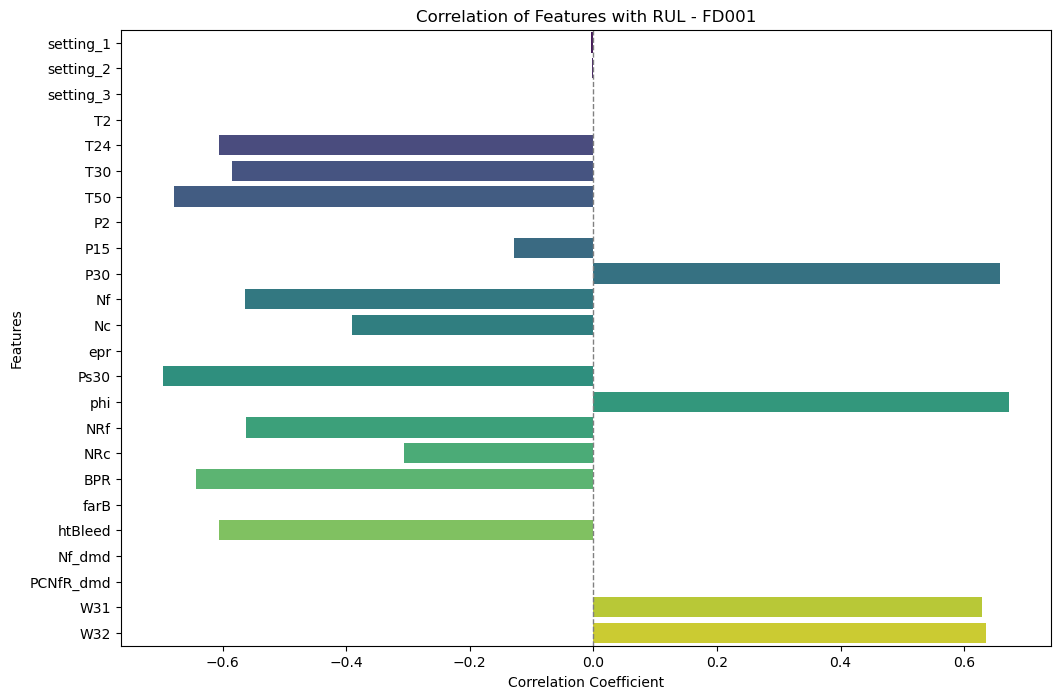

In [92]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming train_data is already loaded
# Drop unnecessary columns for correlation calculation
features = train_data.drop(columns=['unit_number', 'time_in_cycles'])

# Calculate correlation with RUL
correlation_with_rul = features.corr()['RUL'].drop('RUL')

# Create a DataFrame for the correlations
correlation_data = pd.DataFrame(correlation_with_rul).reset_index()
correlation_data.columns = ['Feature', 'Correlation']

# Display the correlation data
print(correlation_data)

# Visualization using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='Correlation', y='Feature', data=correlation_data, palette='viridis')

plt.title('Correlation of Features with RUL - FD001')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(x=0, color='grey', linestyle='--', linewidth=1)
plt.show()

      Feature        VIF
0   setting_1   1.001747
1   setting_2   1.000910
2         T24   2.638856
3         T30   2.289804
4         T50   4.578896
5         P15   1.031186
6         P30   4.330453
7          Nf   4.712036
8          Nc  17.844748
9        Ps30   5.999617
10        phi   5.266435
11        NRf   4.702103
12        NRc  17.255307
13        BPR   3.298742
14    htBleed   2.559623
15        W31   3.061177
16        W32   3.108977


C:\Users\maggi\AppData\Local\Temp\ipykernel_17944\776401793.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='VIF', y='Feature', data=vif_data, palette='viridis')


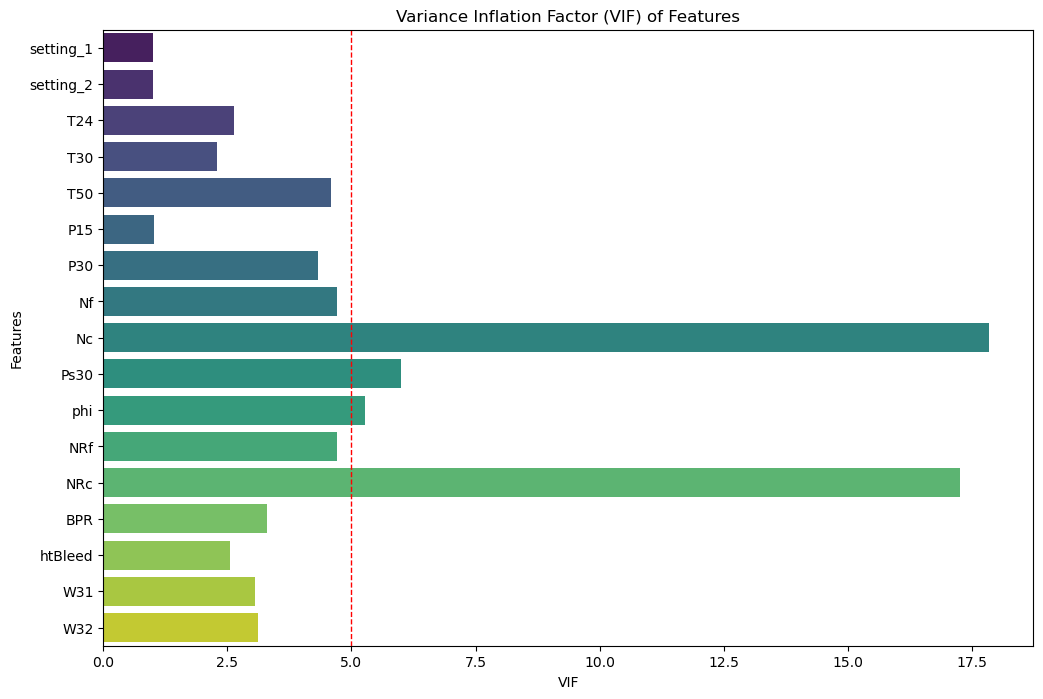

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

# Drop unnecessary columns
features = train_data.drop(columns=['unit_number', 'time_in_cycles', 'RUL'])

# Standardize the data
scaler = StandardScaler()
x = scaler.fit_transform(features)

# Create a DataFrame for the standardized data
standardized_data = pd.DataFrame(x, columns=features.columns)

# Remove features with zero variance
non_zero_variance_features = standardized_data.loc[:, standardized_data.var() != 0]

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = non_zero_variance_features.columns
vif_data['VIF'] = [variance_inflation_factor(non_zero_variance_features.values, i) for i in range(non_zero_variance_features.shape[1])]

# Display the VIF data
print(vif_data)

# Visualization using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x='VIF', y='Feature', data=vif_data, palette='viridis')

# Add vertical dashed red line at VIF = 5
plt.axvline(x=5, color='red', linestyle='--', linewidth=1)

plt.title('Variance Inflation Factor (VIF) of Features')
plt.xlabel('VIF')
plt.ylabel('Features')
plt.show()

In [94]:
# Identify features with VIF greater than 10
high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature']
high_vif_features

8       Nc
9     Ps30
10     phi
12     NRc
Name: Feature, dtype: object

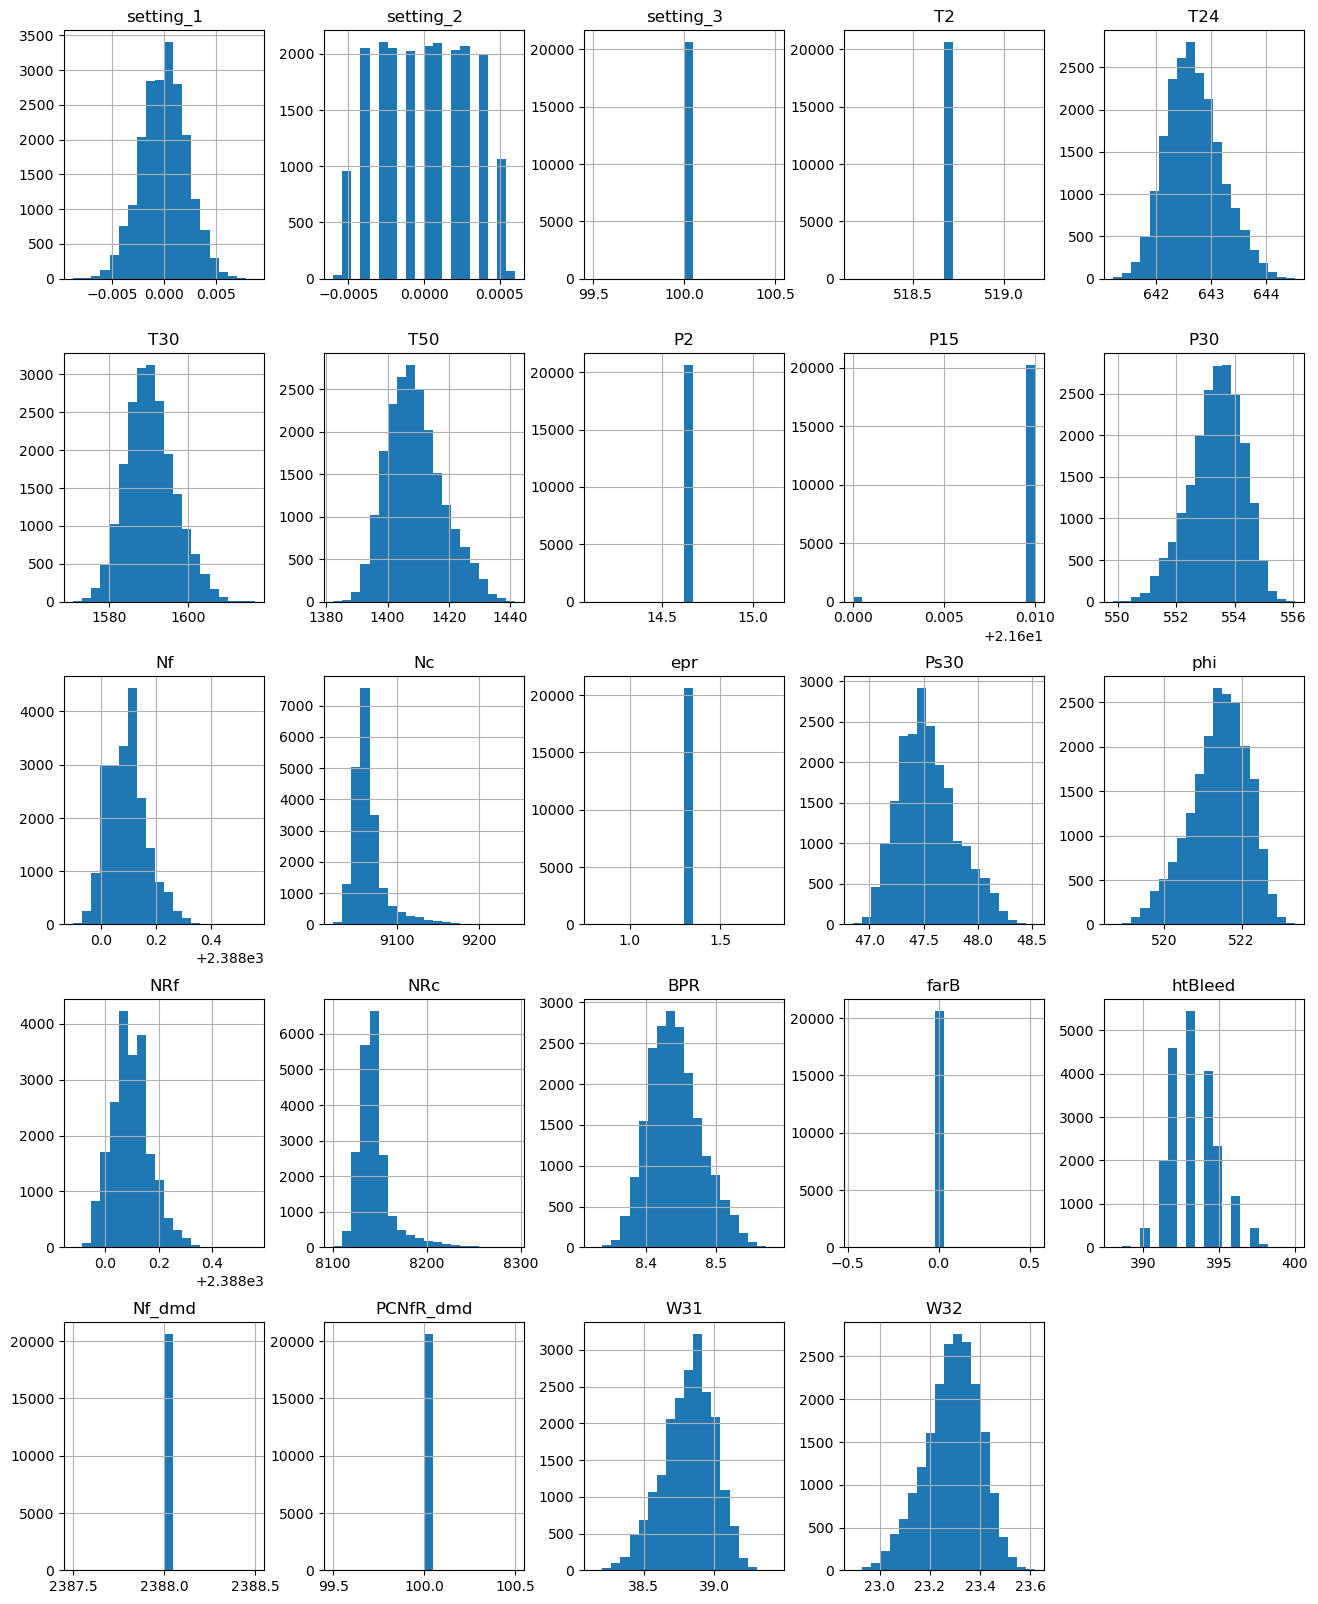

In [95]:
# Assuming train_data is already loaded
features = train_data.drop(columns=['unit_number', 'time_in_cycles', 'RUL'])

# Plot histograms for each feature
features.hist(figsize=(16, 20), bins=20)
plt.title('FD001 Features')
plt.show()